In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2024-06-12 19:11:19.006426: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 19:11:19.036951: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 19:11:19.037500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:11:19.611440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-12 19:11:20.455817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tqdm.auto import tqdm

from typing import Any, Callable, Sequence, Union
import numpy as np
import scipy.stats as stats
import pandas as pd

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb

from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaborLayerLogSigma_, GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

import dm_pix as pix

In [3]:
# dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
# dst = KADIK10K("/media/disk/databases/BBDD_video_image/Image_Quality/KADIK10K/")
# dst = PIPAL("/media/disk/databases/BBDD_video_image/Image_Quality/PIPAL/")
# dst = KADIK10K("/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K/")
dst = KADIK10K("/media/databases/IQA/KADIK10K/")

In [4]:
img, img_dist, mos = next(iter(dst.dataset))
img.shape, img_dist.shape, mos.shape

(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [5]:
# id = "t71plb39"
# id = "0udemln0" # J&H init
# id = "1gegnzhb" # 16O NoA
# id = "x9wpdonj" # 16O A
# id = "o77ngu84" # 128 Gabor_Free_A
id = "7411c6yz" # 128 Gabor_Free_A_GDNGamma_J&HFixed_CS-GaussFixed

In [6]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")

In [7]:
config = ConfigDict(prev_run.config["_fields"])
config

A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_GABORS: 128
SEED: 42
TRAIN_CS: false
TRAIN_JH: false
USE_BIAS: false
USE_GAMMA: true
ZERO_MEAN: true

In [8]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

In [9]:
dst_rdy = dst.dataset.batch(config.BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [10]:
#| exporti
class FreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between frequencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):
        gamma_f = self.param("gamma_f",
                             k_array(1/0.4, arr=fmean),
                             (inputs.shape[-1],))
        gamma_theta = self.param("gamma_theta",
                                 equal_to(jnp.ones(shape=(len(theta_mean),)) * 20),
                                 (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, 1)
        kernel = kernel[None,None,:,:]
        # kernel = jnp.tile(kernel, reps=n_groups)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, A=1):
        return A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [11]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = FreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [12]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs = GDNGamma()(inputs)
        else: outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaRepeat(features=config.N_GABORS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

## Define the metrics with `clu`

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [14]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [15]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Define evaluation step

In [16]:
@jax.jit
def compute_distance(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    
    ## Forward pass through the model
    img_pred = state.apply_fn({"params": state.params, **state.state}, img, train=False)
    img_dist_pred = state.apply_fn({"params": state.params, **state.state}, img_dist, train=False)

    ## Calculate the distance
    dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
    
    ## Calculate pearson correlation
    return dist

## Load the pretrained model!

In [17]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))

2024-06-12 19:11:28.874745: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [18]:
def check_trainable(path):
    return False
    # return ("A" in path) or ("alpha_achrom" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [19]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [20]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count, trainable_param_count

(1845, 1845)

In [21]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [22]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [23]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))

In [24]:
# Before actually training the model we're going to set up the checkpointer to be able to save our trained models:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [25]:
# Load weights
state = orbax_checkpointer.restore(os.path.join(prev_run.dir,"model-best"), item=state)

## Evaluate!

In [26]:
import matplotlib.pyplot as plt

In [35]:
img_n = img.numpy()
h, w, c = img_n.shape
h, w, c

(384, 512, 3)

In [78]:
def remove_high_freqs(img):
    img_fft = jnp.fft.fft2(img, axes=(0,1))
    img_fft = jnp.fft.fftshift(img_fft, axes=(0,1))
    img_fft = img_fft.at[0:h//4].set(0)
    img_fft = img_fft.at[-h//4:].set(0)
    img_fft = img_fft.at[:,0:w//4].set(0)
    img_fft = img_fft.at[:,-w//4:].set(0)
    img_mod = jnp.fft.ifft2(jnp.fft.ifftshift(img_fft, axes=(0,1)), axes=(0,1))
    img_mod = jnp.abs(img_mod)
    img_mod = jnp.clip(img_mod, a_min=0., a_max=1.)
    return img_mod

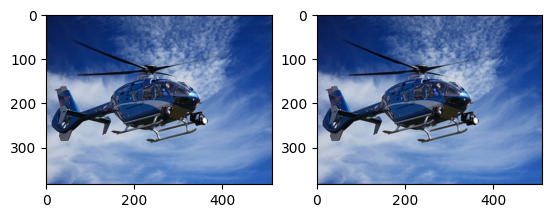

In [88]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(img_n)
axes[1].imshow(img_mod:=remove_high_freqs(img_n))
plt.show()

In [81]:
pred, extras = state.apply_fn({"params": state.params, **state.state}, img[None,...].numpy(), train=False, capture_intermediates=True)
inter_color = extras["intermediates"]
pred, extras = state.apply_fn({"params": state.params, **state.state}, img_mod[None,...], train=False, capture_intermediates=True)
inter_mod = extras["intermediates"]

In [85]:
def get_diffs(t1, t2):
    def normalized_diff(x, y):
        m, M = jnp.min(jnp.array([x, y])), jnp.max(jnp.array([x, y]))
        x = (x-m)/(M-m)
        y = (y-m)/(M-m)
        return jnp.mean(jnp.square(x-y))**(1/2)
    diffs = jax.tree_util.tree_map(lambda x,y: jnp.mean((x-y)**2), t1, t2)
    # diffs = jax.tree_util.tree_map(lambda x,y: normalized_diff(x,y), t1, t2)
    diffs = {k[0]:v[0] for k,v in flax.traverse_util.flatten_dict(diffs).items() if len(k)==2}
    diffs["GaborLayerGammaRepeat_0"] = diffs["GaborLayerGammaRepeat_0"][0]
    return diffs

In [86]:
diffs_mod = get_diffs(inter_mod, inter_color)
diffs_mod

{'CenterSurroundLogSigmaK_0': Array(0.00119086, dtype=float32),
 'Color': Array(0.0004627, dtype=float32),
 'GDNGamma_0': Array(0.00122265, dtype=float32),
 'GDNGaussian_0': Array(0.00701701, dtype=float32),
 'GDNSpatioFreqOrient_0': Array(0.00144158, dtype=float32),
 'GDN_0': Array(0.00042318, dtype=float32),
 'GaborLayerGammaRepeat_0': Array(0.23813921, dtype=float32)}

In [87]:
pd.DataFrame({"1": diffs_mod}).T.style.highlight_max(axis=1)

,CenterSurroundLogSigmaK_0,Color,GDNGamma_0,GDNGaussian_0,GDNSpatioFreqOrient_0,GDN_0,GaborLayerGammaRepeat_0
1,0.0011908564,0.00046270413,0.0012226487,0.007017014,0.001441583,0.00042317828,0.23813921
